In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import copy
import pickle
import numpy as np
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd

from typing import List

import seismometer as sm

import aplusml
import pad

# Patient properties + model predictions
PATH_TO_OUTPUT_FOLDER = '../output/'
PATH_TO_MERGED_MODEL = '../input/synthetic_pad_inputs.csv'
PATH_TO_PATIENT_PROPERTIES = '../input/synthetic_pad_inputs.csv'
os.makedirs(PATH_TO_OUTPUT_FOLDER, exist_ok=True)

# Workflows
PATH_TO_NURSE_YAML = '../workflows/pad_nurse.yaml'
PATH_TO_DOCTOR_YAML = '../workflows/pad_doctor.yaml'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PAD Tutorial

We use APLUS to compare two model-guided workflows for early detection of peripheral artery disease (PAD): a doctor-driven workflow and a nurse-driven workflow. These workflows are specified in `workflows/pad_doctor.yaml` and `workflows/pad_nurse.yaml`, respectively. The code used to generate the figures in our paper is located in the `tutorials/` directory in `pad.ipynb`. This notebook loads synthetic patient data that is compatible with the `seismometer` library made available by Epic Systems Inc. at https://github.com/epic-open-source/seismometer.

# Patients

In [33]:
df_merged = pd.read_csv(PATH_TO_MERGED_MODEL)
df_merged.head()

Unnamed: 0  id  y  y_hat_dl  y_hat_rf  y_hat_lr  abi_test_pred  \
0           0   0  0  0.004402  0.366115  0.258498       1.094892   
1           1   1  1  0.975202  0.715514  0.725202       0.454507   
2           2   2  1  0.964839  0.771823  0.804440       0.960071   
3           3   3  0  0.020734  0.147411  0.280030       0.929200   
4           4   4  1  0.955437  0.739197  0.842346       0.712719   

   random_resource_priority  
0                      1039  
1                      1559  
2                      1602  
3                       451  
4                      1787

In [34]:
# add model prediction generation time to patient data (randomly generated in the case of this tutorial, which uses synthetic data)
def random_datetimes_or_dates(start, end, out_format='datetime', n=10): 

    '''   
    unix timestamp is in ns by default. 
    I divide the unix time value by 10**9 to make it seconds (or 24*60*60*10**9 to make it days).
    The corresponding unit variable is passed to the pd.to_datetime function. 
    Values for the (divide_by, unit) pair to select is defined by the out_format parameter.
    for 1 -> out_format='datetime'
    for 2 -> out_format=anything else
    '''
    (divide_by, unit) = (10**9, 's') if out_format=='datetime' else (24*60*60*10**9, 'D')

    start_u = start.value//divide_by
    end_u = end.value//divide_by

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit=unit) 

start = pd.to_datetime('2015-01-01')
end = pd.to_datetime('2018-01-01')
random_datetimes = random_datetimes_or_dates(start, end, n=4452)
df_merged.insert(8, "ScoringTime", random_datetimes, True)

In [35]:
# run Seismometer startup to generate Seismometer formatted data
sm.run_startup(config_path="./seismometer/", predictions_frame=df_merged)

# Model Settings

In [36]:
THRESHOLDS = np.linspace(0, 1, 101)
MODELS = ['dl', 'rf', 'lr',]

# Nurse-Driven Workflow

### Workflow

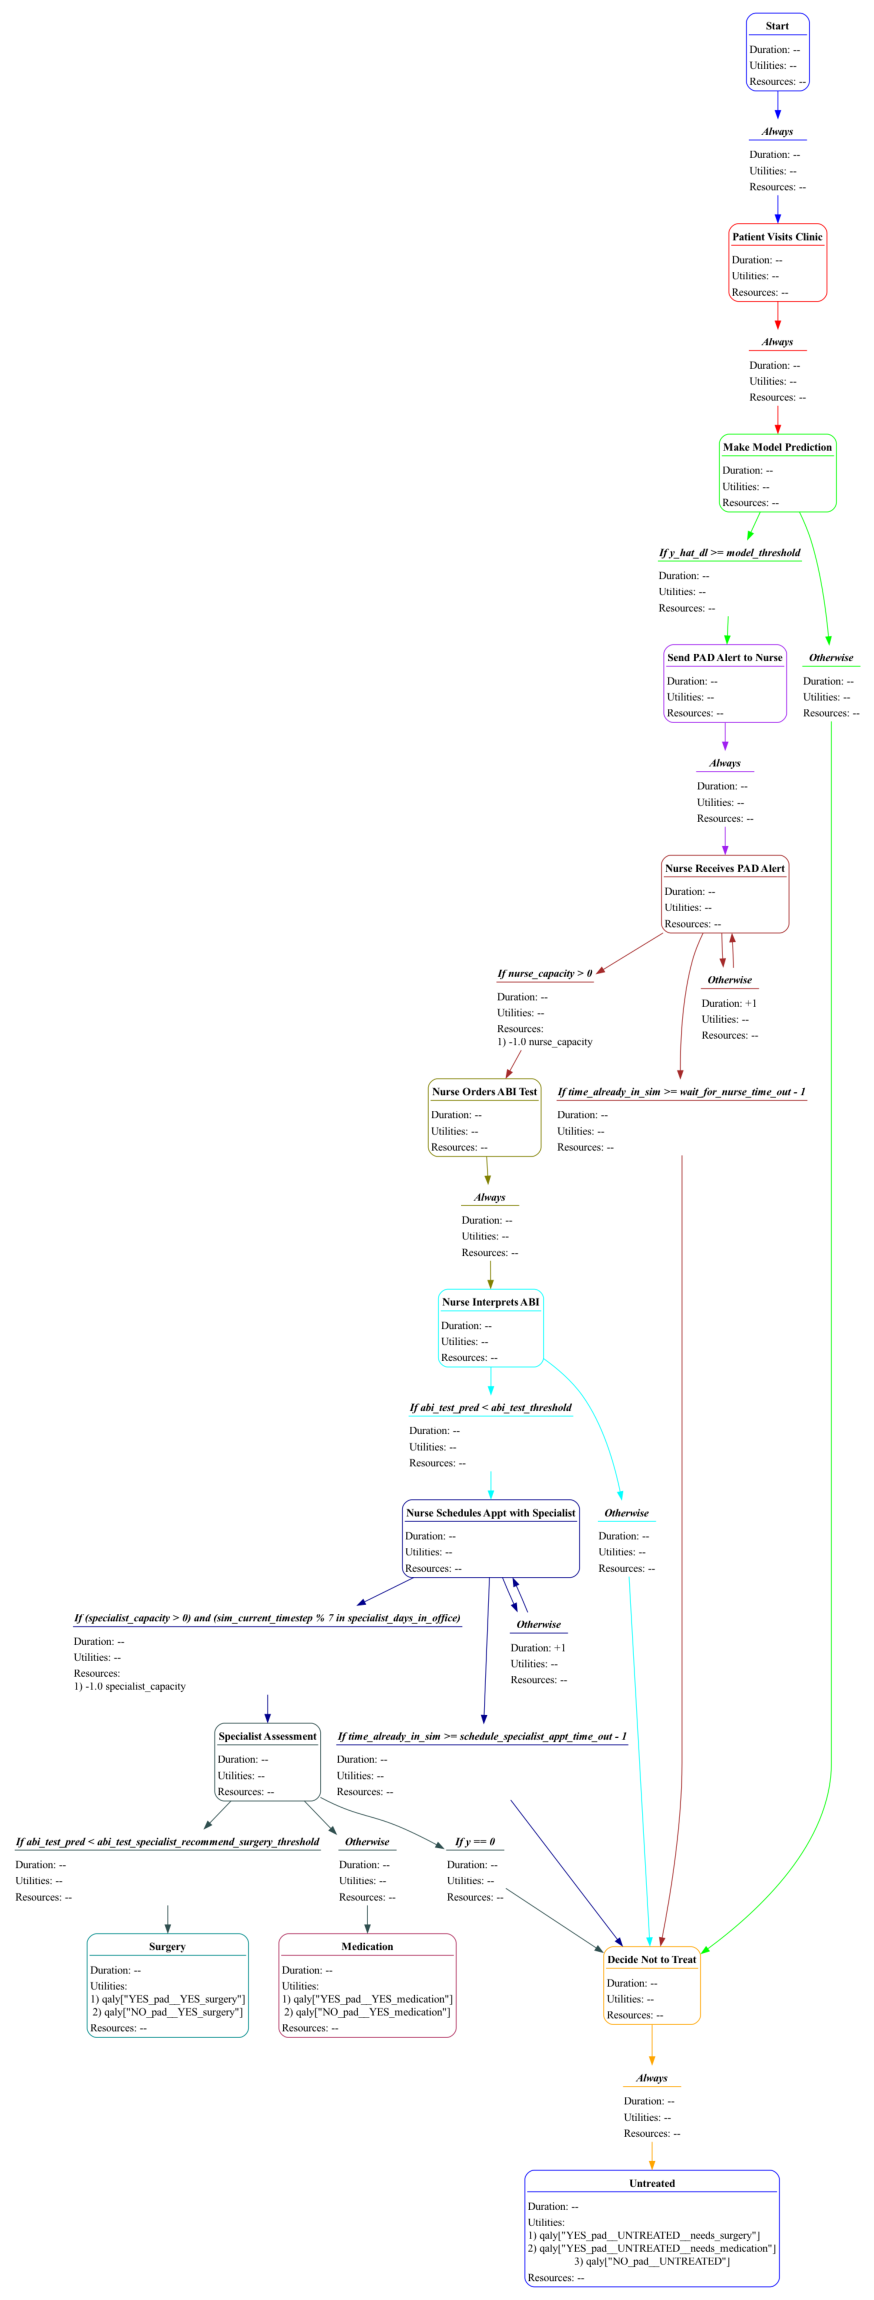

In [37]:
simulation = aplusml.load_simulation(PATH_TO_NURSE_YAML, PATH_TO_PATIENT_PROPERTIES)
simulation.draw_workflow_diagram(figsize=(30,30))

### Patients

Note: this can be reused for doctor workflow b/c they have the same set of patient properties

In [38]:
all_patients = pad.generate_patient_list_seismometer(simulation, sm.Seismogram().dataframe, mean_admits_per_day=35, num_days=500)
all_patients[0].properties

{'abi_test_pred': 1.1136177749405745,
 'y': 0,
 'y_hat_dl': 0.09457176676599,
 'y_hat_rf': 0.2558641172832581,
 'y_hat_lr': 0.3016279067016583,
 'random_resource_priority': 3253}

### Simulate Workflow

In [39]:
def generate_pkl_path(intro: str, patients: List[aplusml.Patient], values: list, specialist_capacity: int, is_ranked_screening: bool, path_to_yaml: str) -> str:
    pkl_name: str = (intro +
                     str(is_ranked_screening) + "_" +
                     str(specialist_capacity) + "_" +
                     "-".join([str(x) for x in values]) + "_" +
                     str(len(patients)) + "_" +
                     os.path.basename(path_to_yaml).split('.')[0] + "_" + 
                     ".pkl")
    pkl_path: str = os.path.join(PATH_TO_OUTPUT_FOLDER, pkl_name)
    os.makedirs(os.path.dirname(pkl_path), exist_ok=True)
    return pkl_path

def load_cached_pkl(pkl_path: str):
    with open(pkl_path, 'rb') as fd:
        results = pickle.load(fd)
    model_2_result, baseline_2_result = results['model'], results['baseline']
    return model_2_result, baseline_2_result

def generate_results(intro: str, patients: List[aplusml.Patient], values: list, specialist_capacity: int, is_ranked_screening: bool, path_to_yaml: str, settings, func_setup_optimistic):
    pkl_path: str = generate_pkl_path(intro, patients, values, specialist_capacity, is_ranked_screening, path_to_yaml)
    if os.path.exists(pkl_path):
        print(f"Loading file from {pkl_path}")
        model_2_result, baseline_2_result = load_cached_pkl(pkl_path)
    else:
        print(f"Didn't find {pkl_path}, recreating from scratch")
        labels = [f"{x}" for x in values]
        model_2_result, baseline_2_result = pad.run_test(patients,
                                                         labels,
                                                         settings,
                                                         MODELS,
                                                         THRESHOLDS,
                                                         path_to_yaml,
                                                         PATH_TO_PATIENT_PROPERTIES,
                                                         is_patient_sort_by_y_hat=is_ranked_screening,
                                                         func_setup_optimistic=func_setup_optimistic)
        with open(pkl_path, 'wb') as fd:
            pickle.dump({
                'model': model_2_result,
                'baseline': baseline_2_result,
            }, fd)
    return model_2_result, baseline_2_result

def show_ribbon_plots(model_2_result, label_sort_order, label_title):
    p1 = aplusml.plot.plot_mean_utility_v_threshold('Deep Learning', model_2_result['dl'],
                                                    label_sort_order=label_sort_order,
                                                    label_title=label_title)
    p2 = aplusml.plot.plot_mean_utility_v_threshold('Random Forest', model_2_result['rf'],
                                                    label_sort_order=label_sort_order,
                                                    label_title=label_title)
    p3 = aplusml.plot.plot_mean_utility_v_threshold('Logistic Regression', model_2_result['lr'],
                                                    label_sort_order=label_sort_order,
                                                    label_title=label_title)
    print(p1)
    print(p2)
    print(p3)

def show_dodged_bar_mean_utility_plot(title: str, df_, label_sort_order, label_title, is_percent_of_optimistic):
    p = aplusml.plot.plot_dodged_bar_mean_utilities(title,
                                                    df_,
                                                    label_sort_order=label_sort_order,
                                                    color_sort_order=[
                                                        'none', 'all', 'lr', 'rf', 'dl', ],
                                                    color_names=[
                                                        'Treat\nNone', 'Treat\nAll', 'Logistic\nRegression', 'Random\nForest', 'Deep\nLearning'
                                                    ],
                                                    is_percent_of_optimistic=is_percent_of_optimistic,
                                                    x_label=label_title)
    print(p)

def show_line_mean_utility_plot(title: str, df_, label_sort_order, label_title, is_percent_of_optimistic):
    df_['group'] = df_['color']
    p = aplusml.plot.plot_line_mean_utilities(title,
                                                df_,
                                                group_sort_order=None,
                                                shape_sort_order=None,
                                                color_title='',
                                                shape_title='',
                                                label_sort_order=label_sort_order,
                                                groups_to_drop=['none', ],
                                                color_sort_order=['all', 'lr', 'rf', 'dl', ],
                                                color_names=[
                                                    'Treat\nAll', 'Logistic\nRegression', 'Random\nForest', 'Deep\nLearning'
                                                ],
                                                is_percent_of_optimistic=is_percent_of_optimistic,
                                                x_label=label_title)

    print(p)

def show_plots(title, model_2_result, df_, label_sort_order, label_title,
                is_show_ribbon_plot: bool = True,
                is_show_dodged_bar_plot: bool = True,
                is_show_line_plot: bool = True): 
    
    # Ribbon plot
    if is_show_ribbon_plot:
        show_ribbon_plots(model_2_result, label_sort_order, label_title)

    # Dodged bar mean utility plot
    if is_show_dodged_bar_plot:
        show_dodged_bar_mean_utility_plot(title, df_, label_sort_order, label_title, is_percent_of_optimistic=1)
    
    # Line mean utility plot
    if is_show_line_plot:
        show_line_mean_utility_plot(title, df_, label_sort_order, label_title, is_percent_of_optimistic=1)

def simulate_nurse_workflow(patients: List[aplusml.Patient],
                            values: list,
                            specialist_capacity: int = None,
                            is_ranked_screening: bool = True,
                            path_to_yaml: str = None,
                            is_show_ribbon_plot: bool = True,
                            is_show_dodged_bar_plot: bool = True,
                            is_show_line_plot: bool = True):
    values += [ 1e5, ] # 1e5 represents the optimistic case
    
    settings = [{
        'nurse_capacity': {
            'init_amount': x,
            'max_amount': x,
            'refill_amount': x,
            'type': 'resource',
            'refill_duration': 1,
        },
        'specialist_capacity': {
            'type': 'resource',
            'init_amount': specialist_capacity if specialist_capacity else 1e5,
            'max_amount': specialist_capacity if specialist_capacity else 1e5,
            'refill_amount': specialist_capacity if specialist_capacity else 1e5,
            'refill_duration': 1,
        },
    } for x in values]
    model_2_result, baseline_2_result = generate_results('nurse_', patients, values, specialist_capacity, is_ranked_screening, path_to_yaml, settings, pad.setup_nurse_optimistic)

    # Plotting constants
    df_ = pad.plot_helper(model_2_result, {
        'all': baseline_2_result['all'],
        'none': baseline_2_result['none']
    }).rename(columns={'model': 'color'})
    # Use 1e5 as the 'optimistic' case for nurse capacity
    df_ = df_[df_['label'] != 'optimistic']
    df_.loc[df_['label'] == '100000.0', 'label'] = 'optimistic'
    label_sort_order: List[str] = [ str(x) for x in df_['label'].unique() ]
    label_title: str = 'Nurse Capacity'

    for m in MODELS:
        model_2_result[m] = model_2_result[m][model_2_result[m]['label'] != 'optimistic']
        model_2_result[m].loc[model_2_result[m]['label'] == '100000.0', 'label'] = 'optimistic'
        
    screening_name: str = 'ranked screening' if is_ranked_screening else 'thresholded screening'
    title = f'Utility of nurse-driven workflow with {screening_name}'
    show_plots(title, model_2_result, df_, label_sort_order, label_title,
                is_show_ribbon_plot = is_show_ribbon_plot,
                is_show_dodged_bar_plot = is_show_dodged_bar_plot,
                is_show_line_plot = is_show_line_plot)
    

==== Ranked + Specialist Unlimited ====
Loading file from ../output/nurse_True_None_0-1-2-3-4-5-6-7-8-9-10-100000.0_17515_pad_nurse_.pkl


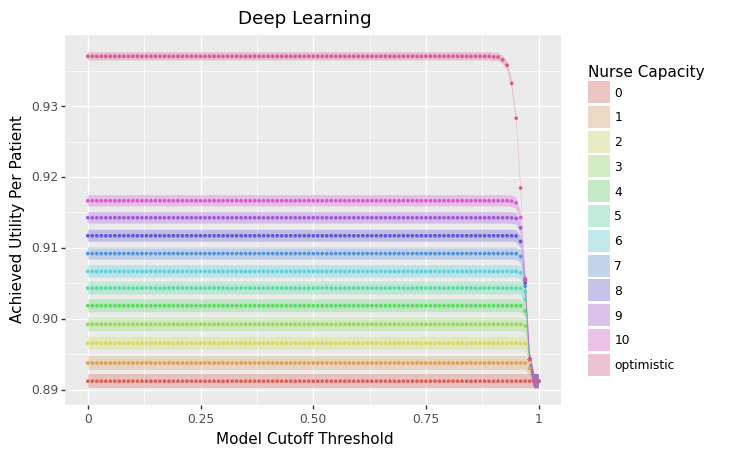

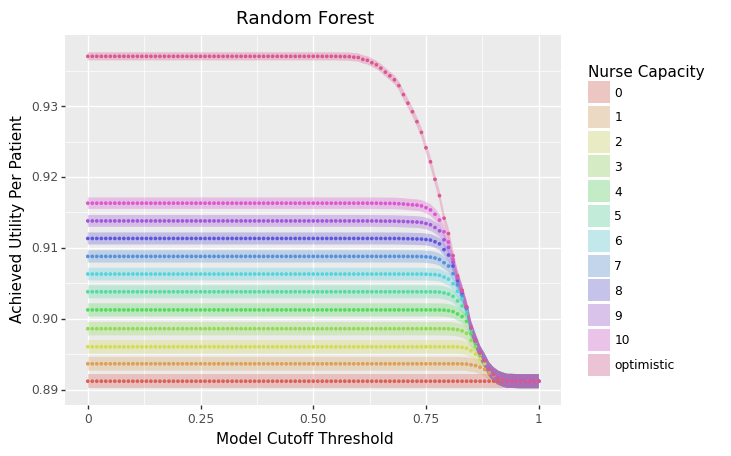

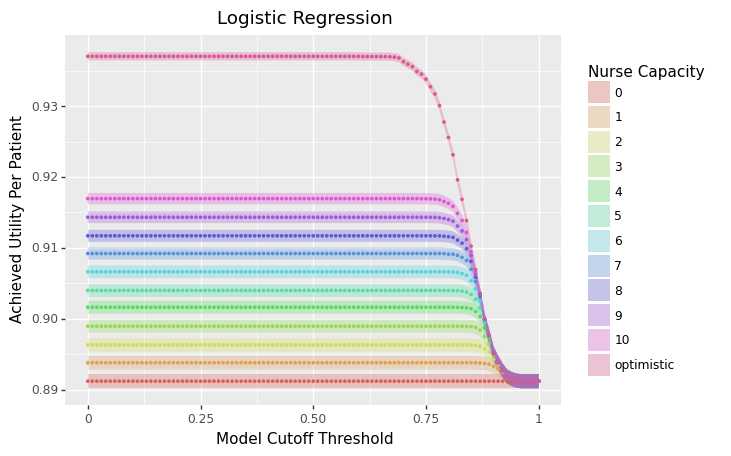

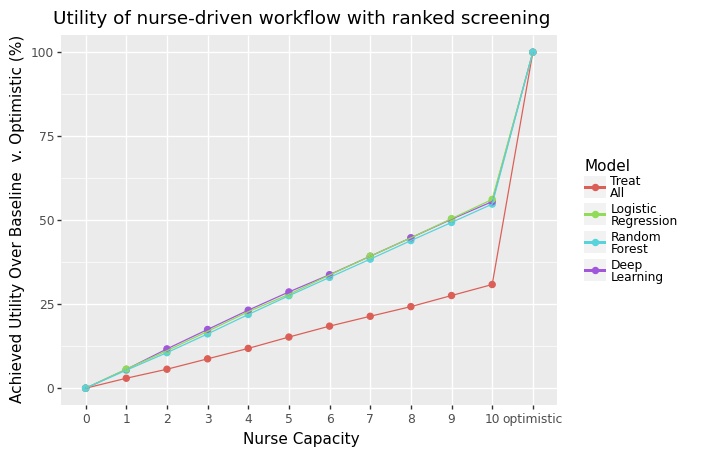


==== Ranked + Specialist Cap (2) ====
Loading file from ../output/nurse_True_2_0-1-2-3-4-5-6-7-8-9-10-100000.0-100000.0_17515_pad_nurse_.pkl


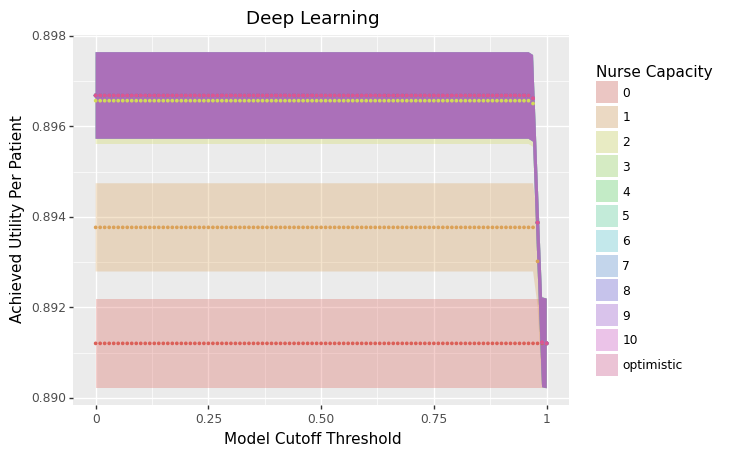

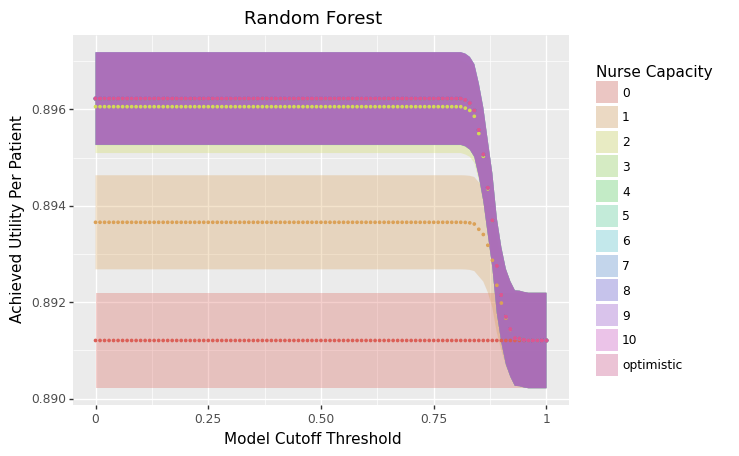

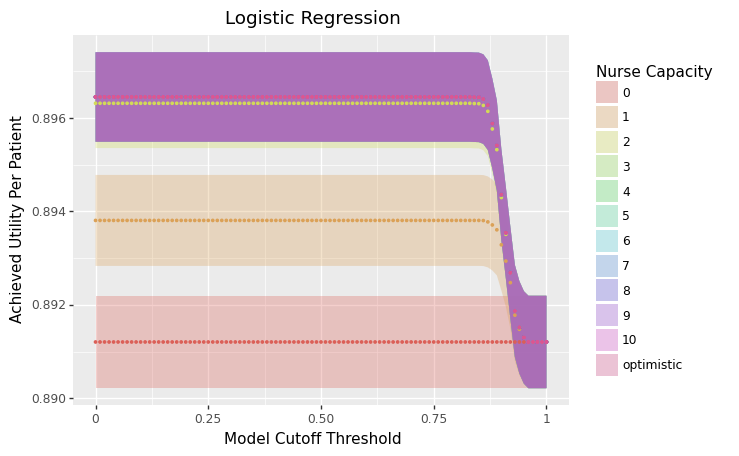

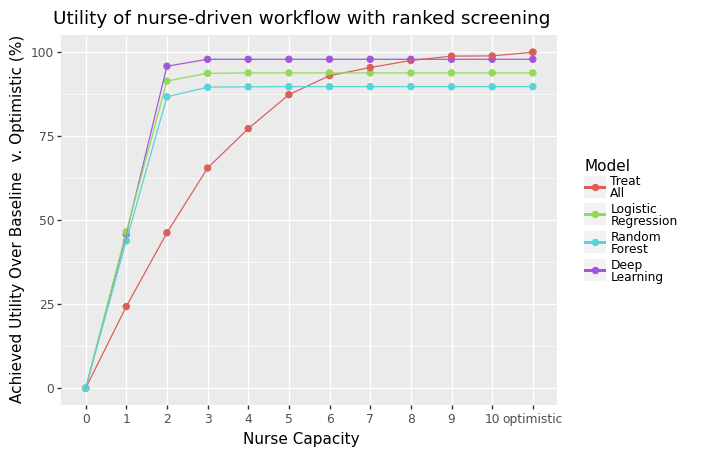


==== Ranked + Specialist Cap (5) ====
Loading file from ../output/nurse_True_5_0-1-2-3-4-5-6-7-8-9-10-100000.0-100000.0-100000.0_17515_pad_nurse_.pkl


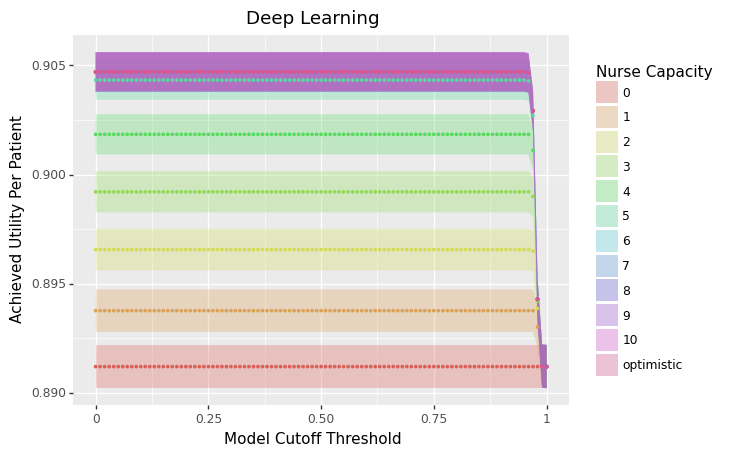

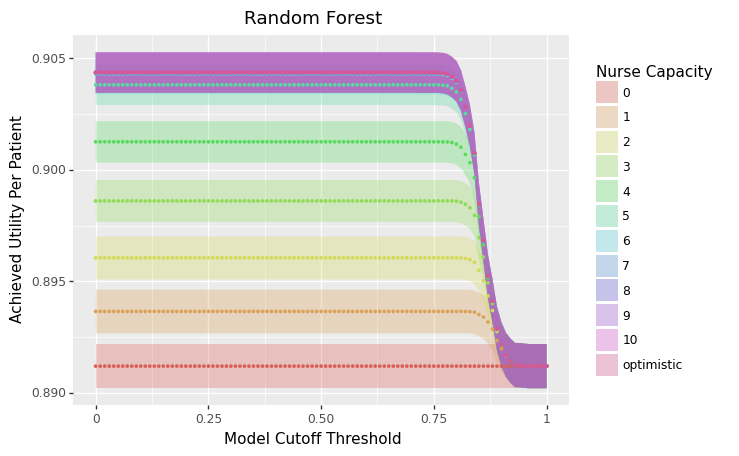

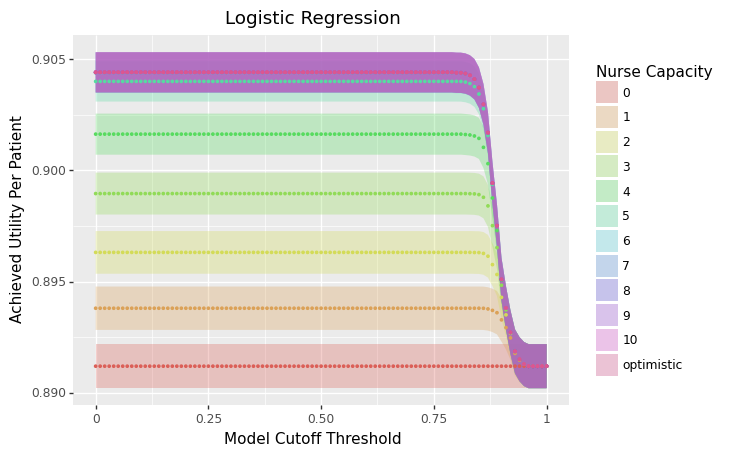

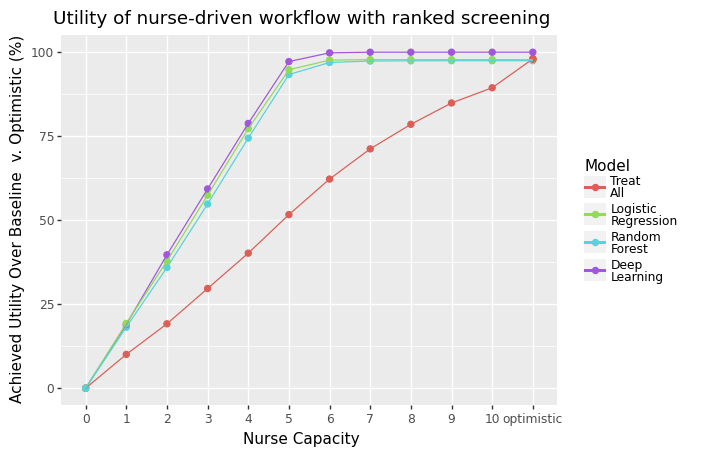


==== Thresholded + Specialist Unlimited ====
Loading file from ../output/nurse_False_None_0-1-2-3-4-5-6-7-8-9-10-100000.0-100000.0-100000.0-100000.0_17515_pad_nurse_.pkl


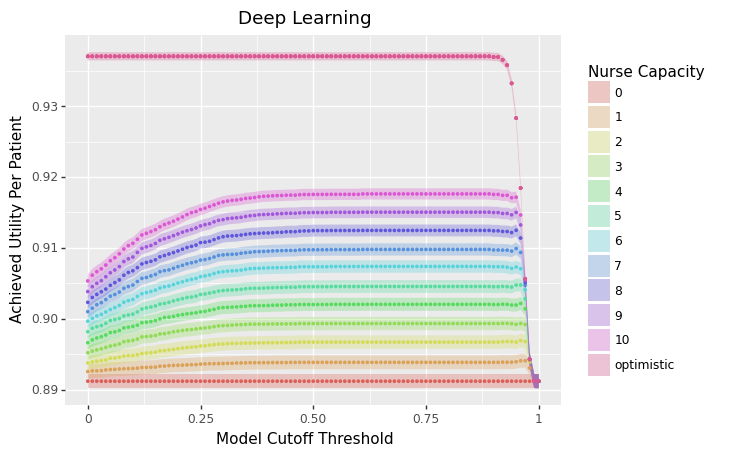

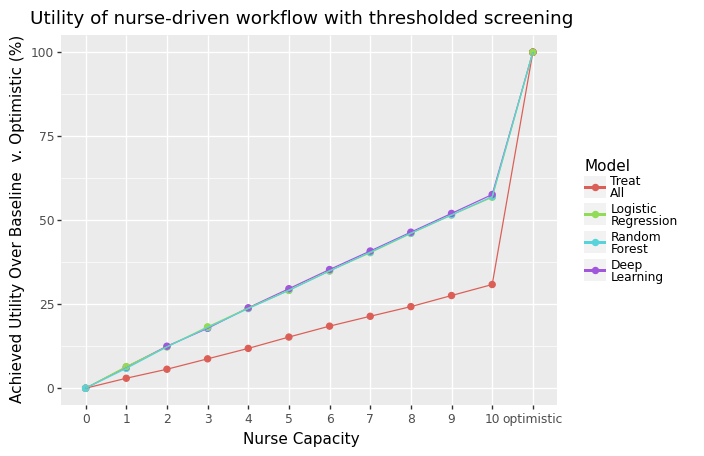


==== Thresholded + Specialist Cap (2) ====
Loading file from ../output/nurse_False_2_0-1-2-3-4-5-6-7-8-9-10-100000.0-100000.0-100000.0-100000.0-100000.0_17515_pad_nurse_.pkl


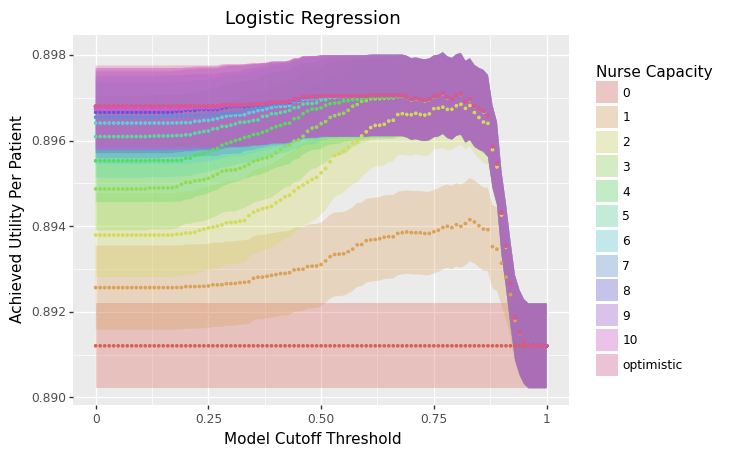


==== Thresholded + Specialist Cap (5) ====
Loading file from ../output/nurse_False_5_0-1-2-3-4-5-6-7-8-9-10-100000.0-100000.0-100000.0-100000.0-100000.0-100000.0_17515_pad_nurse_.pkl


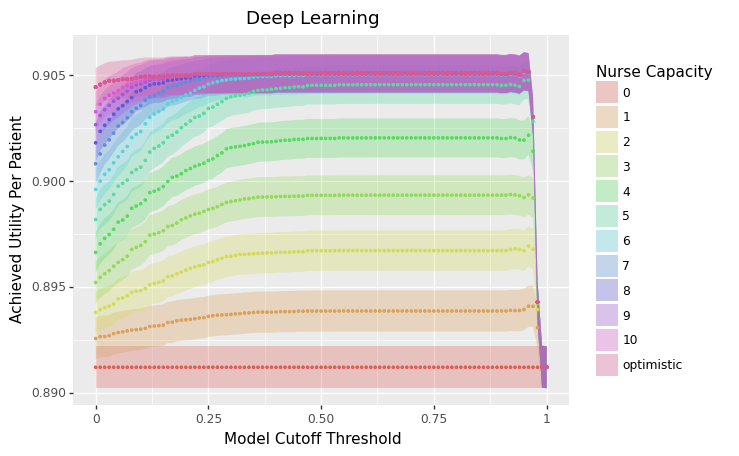

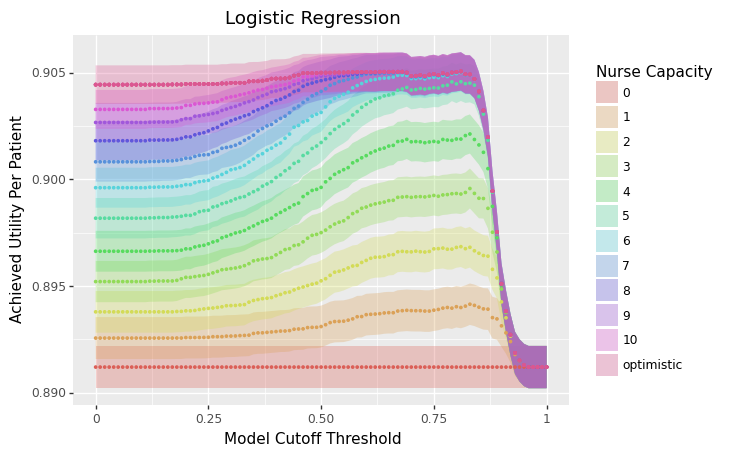

In [40]:
values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]

for is_ranked_screening in [True, False]:
    for specialist_capacity in [None, 2, 5]:
        print(f"==== {'Ranked' if is_ranked_screening else 'Thresholded'} + {'Specialist Unlimited' if specialist_capacity is None else f'Specialist Cap ({specialist_capacity})'} ====")
        simulate_nurse_workflow(copy.deepcopy(all_patients),
                                values,
                                specialist_capacity=specialist_capacity,
                                is_ranked_screening=is_ranked_screening,
                                path_to_yaml=PATH_TO_NURSE_YAML,
                                is_show_dodged_bar_plot=False)

# Doctor-Driven Workflow

### Workflow

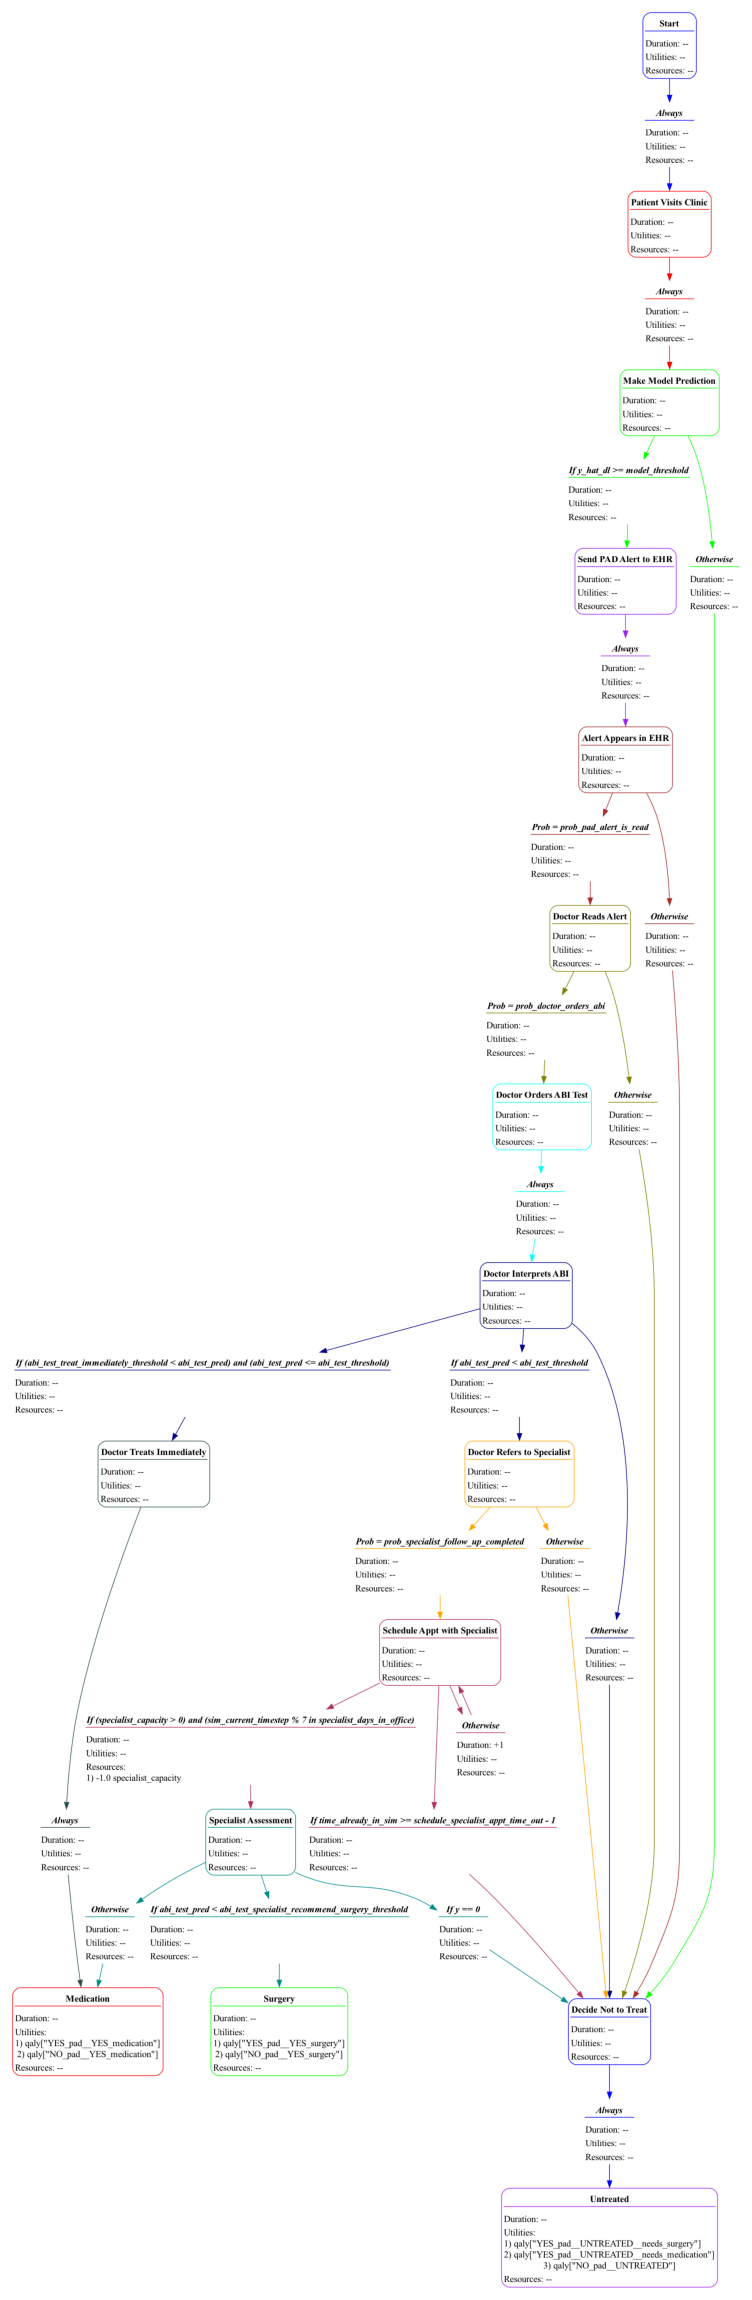

In [41]:
simulation = aplusml.load_simulation(PATH_TO_DOCTOR_YAML, PATH_TO_PATIENT_PROPERTIES)
simulation.draw_workflow_diagram(figsize=(30,30))

### Simulate Workflow

In [42]:
def simulate_doctor_workflow(patients: List[aplusml.Patient],
                            values: list,
                            specialist_capacity: int = None,
                            is_ranked_screening: bool = True,
                            path_to_yaml: str = None,
                            is_show_ribbon_plot: bool = True,
                            is_show_dodged_bar_plot: bool = True,
                            is_show_line_plot: bool = True):
    settings = [{
        'prob_pad_alert_is_read': {
            'type': 'scalar',
            'value': x,
        },
        'specialist_capacity': {
            'type': 'resource',
            'init_amount': specialist_capacity if specialist_capacity else 1e5,
            'max_amount': specialist_capacity if specialist_capacity else 1e5,
            'refill_amount': specialist_capacity if specialist_capacity else 1e5,
            'refill_duration': 1,
        },
    } for x in values]
    model_2_result, baseline_2_result = generate_results('doctor_', patients, values, specialist_capacity, is_ranked_screening, path_to_yaml, settings, pad.setup_doctor_optimistic)

    # Plotting constants
    df_ = pad.plot_helper(model_2_result, {
        'all': baseline_2_result['all'],
        'none': baseline_2_result['none']
    }, threshold=0.5).rename(columns={'model': 'color'})
    # Use prob=1 as the 'optimistic' case
    df_ = df_[df_['label'] != 'optimistic']
    df_.loc[df_['label'] == '1', 'label'] = 'optimistic'
    label_sort_order: list[str] = [ str(x) for x in df_['label'].unique() ]
    label_title: str = 'Probability Doctor Reads Alert'
    for m in MODELS:
        model_2_result[m] = model_2_result[m][model_2_result[m]['label'] != 'optimistic']
        model_2_result[m].loc[model_2_result[m]['label'] == '1', 'label'] = 'optimistic'

    show_plots('Utility of doctor-driven workflow', model_2_result, df_, label_sort_order, label_title,
                is_show_ribbon_plot = is_show_ribbon_plot,
                is_show_dodged_bar_plot = is_show_dodged_bar_plot,
                is_show_line_plot = is_show_line_plot)

==== Thresholded + Specialist Unlimited ====
Loading file from ../output/doctor_False_None_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_pad_doctor_.pkl


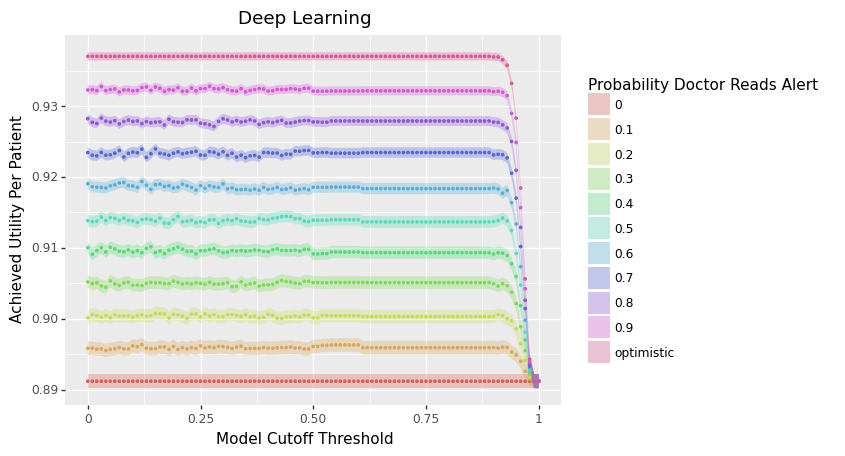

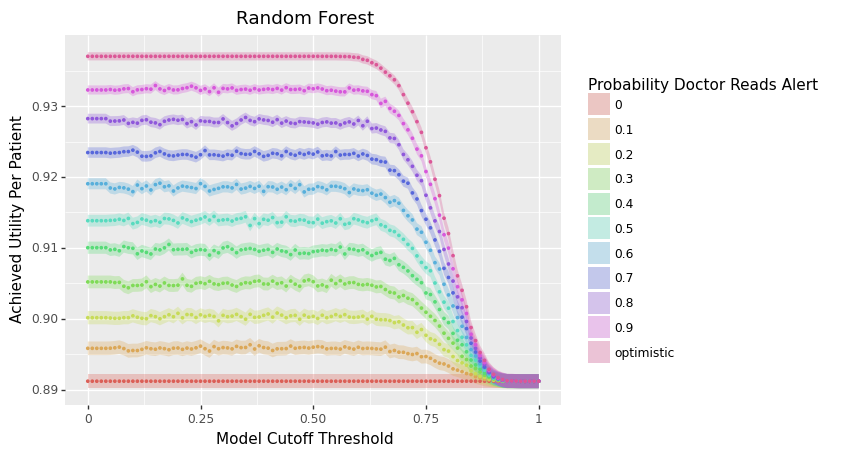

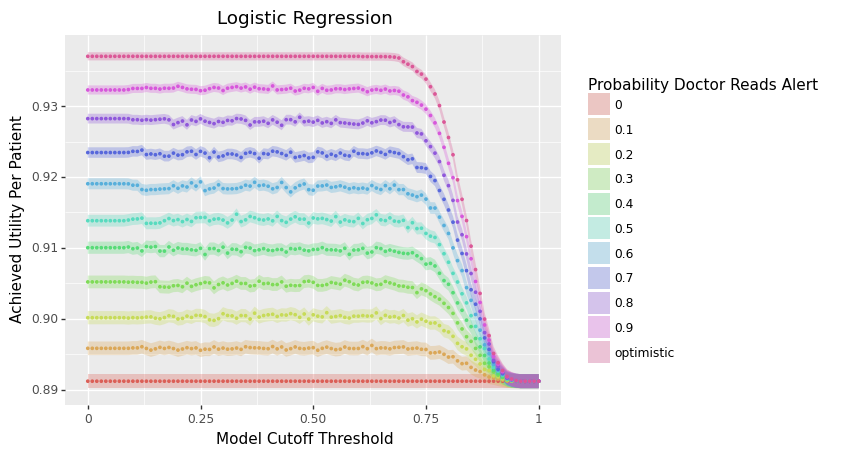

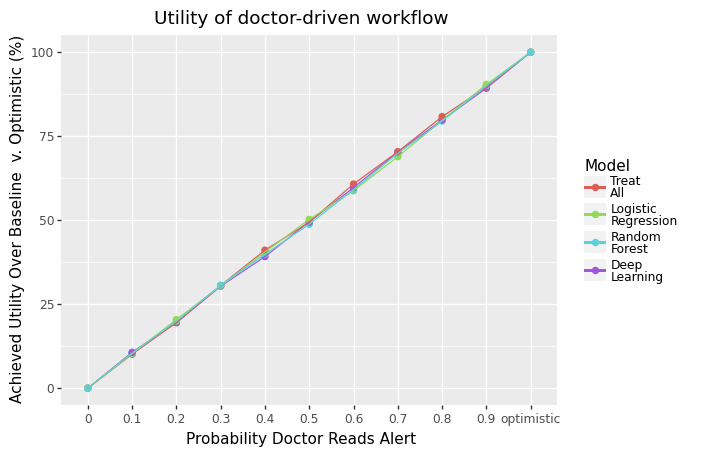


==== Thresholded + Specialist Cap (2) ====
Loading file from ../output/doctor_False_2_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_pad_doctor_.pkl


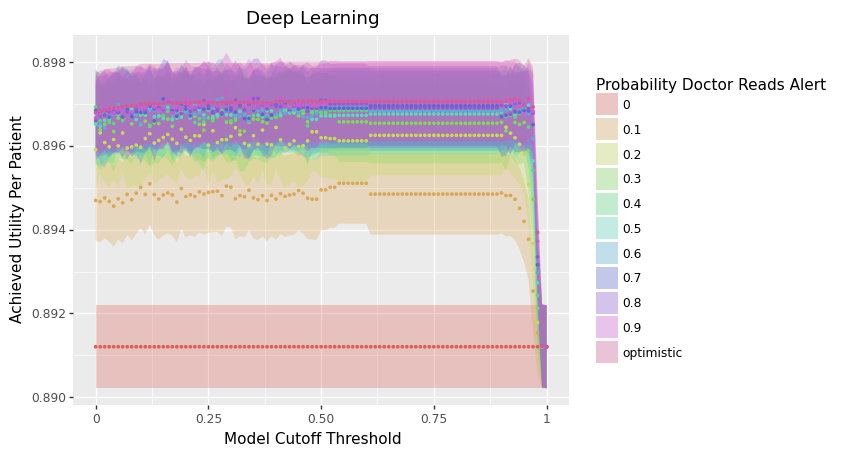

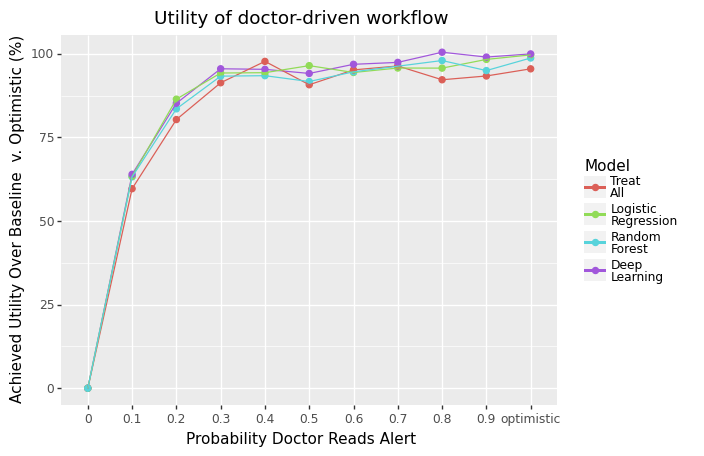


==== Thresholded + Specialist Cap (5) ====
Loading file from ../output/doctor_False_5_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_pad_doctor_.pkl


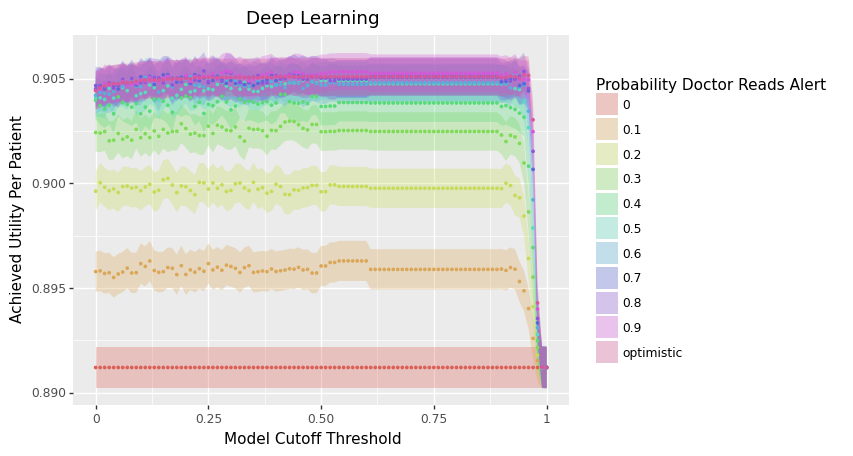

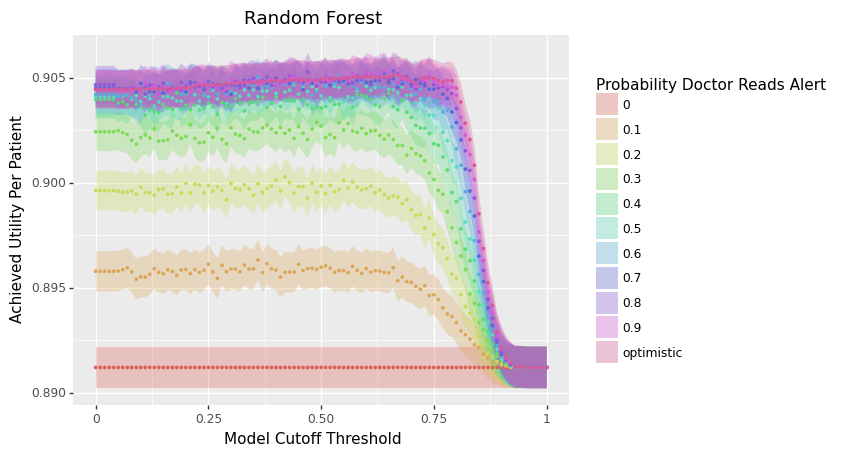

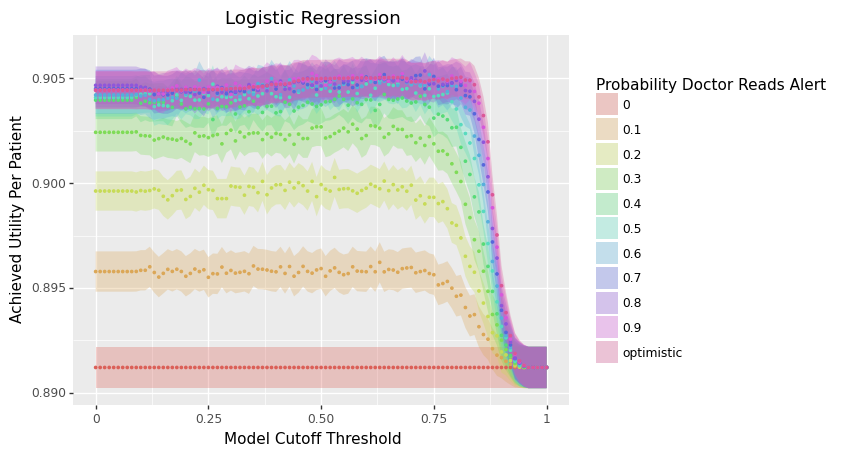

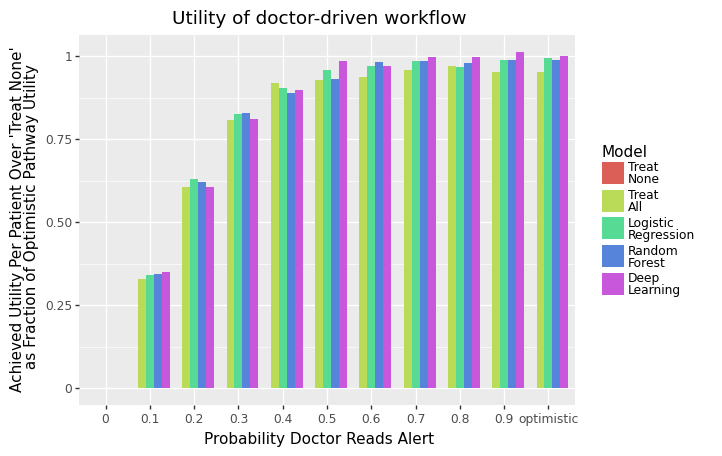

In [43]:
values = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, ]

for is_ranked_screening in [False]:
    for specialist_capacity in [None, 2, 5]:
        print(f"==== {'Ranked' if is_ranked_screening else 'Thresholded'} + {'Specialist Unlimited' if specialist_capacity is None else f'Specialist Cap ({specialist_capacity})'} ====")
        simulate_doctor_workflow(copy.deepcopy(all_patients),
                                values,
                                specialist_capacity=specialist_capacity,
                                is_ranked_screening=is_ranked_screening,
                                path_to_yaml=PATH_TO_DOCTOR_YAML)

# DL Model - Doctor-Driven v. Nurse-Driven Utilities

In [44]:
def compare_doctor_v_nurse(patients: List[aplusml.Patient], specialist_capacity: int):
    nurse_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
    pkl_path: str = generate_pkl_path("nurse_", patients, nurse_values, specialist_capacity, True, PATH_TO_NURSE_YAML)
    if os.path.exists(pkl_path):
        print(f"Loading file from {pkl_path}")
        with open(pkl_path, 'rb') as fd:
            results = pickle.load(fd)
        m2r_nurse, b2r_nurse = results['model'], results['baseline']
    else:
        print(f"Creating file at {pkl_path}")
        # Nurse
        labels = [f"{x}" for x in nurse_values ]
        settings = [{
                        'nurse_capacity' : {
                            'type' : 'resource',
                            'init_amount' : x,
                            'max_amount' : x,
                            'refill_amount' : x,
                            'refill_duration' : 1,
                        },
                        'specialist_capacity' : {
                            'type' : 'resource',
                            'init_amount' : specialist_capacity,
                            'max_amount' : specialist_capacity,
                            'refill_amount' : specialist_capacity,
                            'refill_duration' : 1,
                        },
                    } for x in nurse_values ]
        m2r_nurse, b2r_nurse = pad.run_test(patients,
                                                labels,
                                                settings,
                                                MODELS,
                                                THRESHOLDS, # Only need to test one threshold because using ranked threshold
                                                PATH_TO_NURSE_YAML,
                                                PATH_TO_PATIENT_PROPERTIES,
                                                is_patient_sort_by_y_hat=True,
                                                func_setup_optimistic=pad.setup_nurse_optimistic)
        with open(pkl_path, 'wb') as fd:
            pickle.dump({
                'model': m2r_nurse,
                'baseline': b2r_nurse,
            }, fd)

    # Doctor
    doctor_values = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, ]
    pkl_path: str = generate_pkl_path("doctor_", patients, doctor_values, specialist_capacity, False, PATH_TO_DOCTOR_YAML)
    if os.path.exists(pkl_path):
        print(f"Loading file from {pkl_path}")
        with open(pkl_path, 'rb') as fd:
            results = pickle.load(fd)
        m2r_doctor, b2r_doctor = results['model'], results['baseline']
    else:
        print(f"Creating file at {pkl_path}")
        labels = [f"{x}" for x in doctor_values ]
        settings = [{
                        'prob_pad_alert_is_read' : {
                            'type' : 'scalar',
                            'value' : x,
                        },
                        'specialist_capacity' : {
                            'type' : 'resource',
                            'init_amount' : specialist_capacity,
                            'max_amount' : specialist_capacity,
                            'refill_amount' : specialist_capacity,
                            'refill_duration' : 1,
                        },
                    } for x in doctor_values ]
        m2r_doctor, b2r_doctor = pad.run_test(copy.deepcopy(all_patients),
                                                labels,
                                                settings,
                                                MODELS,
                                                THRESHOLDS,
                                                PATH_TO_DOCTOR_YAML,
                                                PATH_TO_PATIENT_PROPERTIES,
                                                is_patient_sort_by_y_hat=False,
                                                func_setup_optimistic=pad.setup_doctor_optimistic)
        with open(pkl_path, 'wb') as fd:
            pickle.dump({
                'model': m2r_doctor,
                'baseline': b2r_doctor,
            }, fd)

    df_nurse = pad.plot_helper(m2r_nurse, b2r_nurse)
    df_doctor = pad.plot_helper(m2r_doctor, b2r_doctor)

    # Calculate baselines
    n_none, d_none = df_nurse[df_nurse['model'] == 'none']['y'].max(), df_doctor[df_doctor['model'] == 'none']['y'].max()
    n_all, d_all = df_nurse[df_nurse['model'] == 'all']['y'].max(), df_doctor[df_doctor['model'] == 'all']['y'].max()
    assert (n_none == d_none), "n_none != d_none"
    assert (n_all == d_all), "n_all != d_all"
    baseline = min([n_none, n_all])
    # Calculate optimistic
    n_optimistic, d_optimistic = df_nurse[df_nurse['label'] == 'optimistic']['y'].max(), df_doctor[df_doctor['label'] == 'optimistic']['y'].max()
    assert (n_optimistic == d_optimistic), "n_optimistic != d_optimistic"
    utility_optimistic = n_optimistic
    # We scale everything by the 'optimistic' pathway that yields the max utility (since there may be multiple 'optimistic' rows)
    df_nurse['y'] = (df_nurse['y'] - baseline) / (utility_optimistic - baseline)
    df_doctor['y'] = (df_doctor['y'] - baseline) / (utility_optimistic - baseline)
    return df_nurse, df_doctor

In [45]:
def plot_line_doctor_v_nurse(df_nurse: pd.DataFrame,
                             df_doctor: pd.DataFrame,
                             model_name: str,
                             specialist_capacity: str):
    fig, ax = plt.subplots(figsize=(10,10))
    n = df_nurse[(df_nurse['model'] == model_name) & (df_nurse['label'] != 'optimistic')]
    d = df_doctor[(df_doctor['model'] == model_name) & (df_doctor['label'] != 'optimistic')]
    d['label'] = d['label'].astype(float)
    nurse_colors = cm.get_cmap('Blues', n.shape[0])(np.linspace(0.5, 1, n.shape[0]))
    for idx, (_, row) in enumerate(n.iterrows()):
        plt.plot([d['label'].min(), d['label'].max()], 
                [row['y'], row['y']], 
                '--', 
                color=nurse_colors[idx])
        plt.text(.8, row['y'], f"Nurse Capacity={row['label']}", backgroundcolor='white')
    if model_name == 'dl':
        model_label = 'Deep Learning'
    elif model_name == 'rf':
        model_label = 'Random Forest'
    elif model_name == 'lr':
        model_label = 'Logistic Regression'
    plt.plot(d['label'], d['y'])
    plt.ylabel('Achieved Utility Over "Treat None" Baseline as Fraction of Optimistic Pathway\'s Utility')
    plt.xlabel('Probability Doctor Reads EHR Alert')
    plt.title(f"Contrasting the utility achieved under a nurse-driven v. doctor-driven workflow\nModel = {model_label} | Specialist capacity = {specialist_capacity}")
    plt.margins(x=0)
    plt.ylim(0, 1)
    blue_patch = mpatches.Patch(color=nurse_colors[-1], label='Nurse-driven workflow')
    red_patch = mpatches.Patch(color='tab:red', label='Doctor-driven Workflow')
    ax.legend(handles=[blue_patch, red_patch], loc='upper left', facecolor='white')
    plt.show()

In [46]:
def plot_heatmap_doctor_v_nurse(df_nurse: pd.DataFrame,
                                df_doctor: pd.DataFrame,
                                model_name: str,
                                specialist_capacity: str,
                                is_discrete_squares: bool = True):
    fig, ax = plt.subplots(figsize=(10,10))
    n = df_nurse[(df_nurse['model'] == model_name) & (df_nurse['label'] != 'optimistic')]
    d = df_doctor[(df_doctor['model'] == model_name) & (df_doctor['label'] != 'optimistic')]
    d['label'] = d['label'].astype(float)
    n['label'] = n['label'].astype(int)
    if model_name == 'dl':
        model_label = 'Deep Learning'
    elif model_name == 'rf':
        model_label = 'Random Forest'
    elif model_name == 'lr':
        model_label = 'Logistic Regression'

    x_axis_labels = sorted([ x for x in list(d['label'].unique()) ], reverse=False)
    y_axis_labels = sorted([ x for x in list(n['label'].unique()) ], reverse=True)
    
    values = np.zeros((len(x_axis_labels), len(y_axis_labels)))
    for i in range(len(x_axis_labels)):
        for j in range(len(y_axis_labels)):
            values[i, j] = n[n['label'] == y_axis_labels[j]]['y'].values[0] - d[d['label'] == x_axis_labels[i]]['y'].values[0]

    im = ax.imshow(values, cmap='seismic')
    
    # colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Incremental Utility Gain', rotation=-90, va="bottom")
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(x_axis_labels)), labels=x_axis_labels, fontsize=13, color='k')
    ax.set_yticks(np.arange(len(y_axis_labels)), labels=y_axis_labels, fontsize=13, color='k')
    ax.grid(False)
    
    if is_discrete_squares:
        # Plot each cell as a discrete square
        # whitespace spacing
        ax.spines[:].set_visible(False)
        ax.set_xticks(np.arange(values.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(values.shape[0]+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.tick_params(which="minor", bottom=False, left=False)

        # Loop over data dimensions and create text annotations.
        text_color_threshold = np.mean(values) + np.std(values)
        textcolors = ["black", "white"]
        for i in range(len(y_axis_labels)):
            for j in range(len(x_axis_labels)):
                text = ax.text(j, i, round(values[i, j], 3), ha="center", va="center", color=textcolors[np.abs(values[i, j]) > text_color_threshold])
    else:
        # Plot cells as continuous phase transition
        # ax.set_aspect('equal')
        ax.imshow(values, cmap='seismic', interpolation='bicubic')
        # ax.pcolormesh(values, cmap='seismic', edgecolors='face')
    
    ax.set_title(f"Incremental Utility Gain of Using Nurse-Driven Over Doctor-Driven Workflow\nModel = {model_label} | Specialist capacity = {specialist_capacity}")
    ax.set_ylabel('Nurse Capacity (total patients/day)', fontsize=13, color='k')
    ax.set_xlabel('Probability Doctor Acts on EHR Alert', fontsize=13, color='k')
    fig.tight_layout()
    plt.show()

In [47]:
df_nurse_5, df_doctor_5 = compare_doctor_v_nurse(copy.deepcopy(all_patients), 5)
df_nurse_all, df_doctor_all = compare_doctor_v_nurse(copy.deepcopy(all_patients), 1e9)

Loading file from ../output/nurse_True_5_0-1-2-3-4-5-6-7-8-9-10_17515_pad_nurse_.pkl
Loading file from ../output/doctor_False_5_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_pad_doctor_.pkl
Loading file from ../output/nurse_True_1000000000.0_0-1-2-3-4-5-6-7-8-9-10_17515_pad_nurse_.pkl
Loading file from ../output/doctor_False_1000000000.0_0-0.1-0.2-0.3-0.4-0.5-0.6-0.7-0.8-0.9-1_17515_pad_doctor_.pkl


/var/folders/8k/4sr8k5px4pv27s0847cxmvfm0000gp/T/ipykernel_59421/488764404.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/8k/4sr8k5px4pv27s0847cxmvfm0000gp/T/ipykernel_59421/488764404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


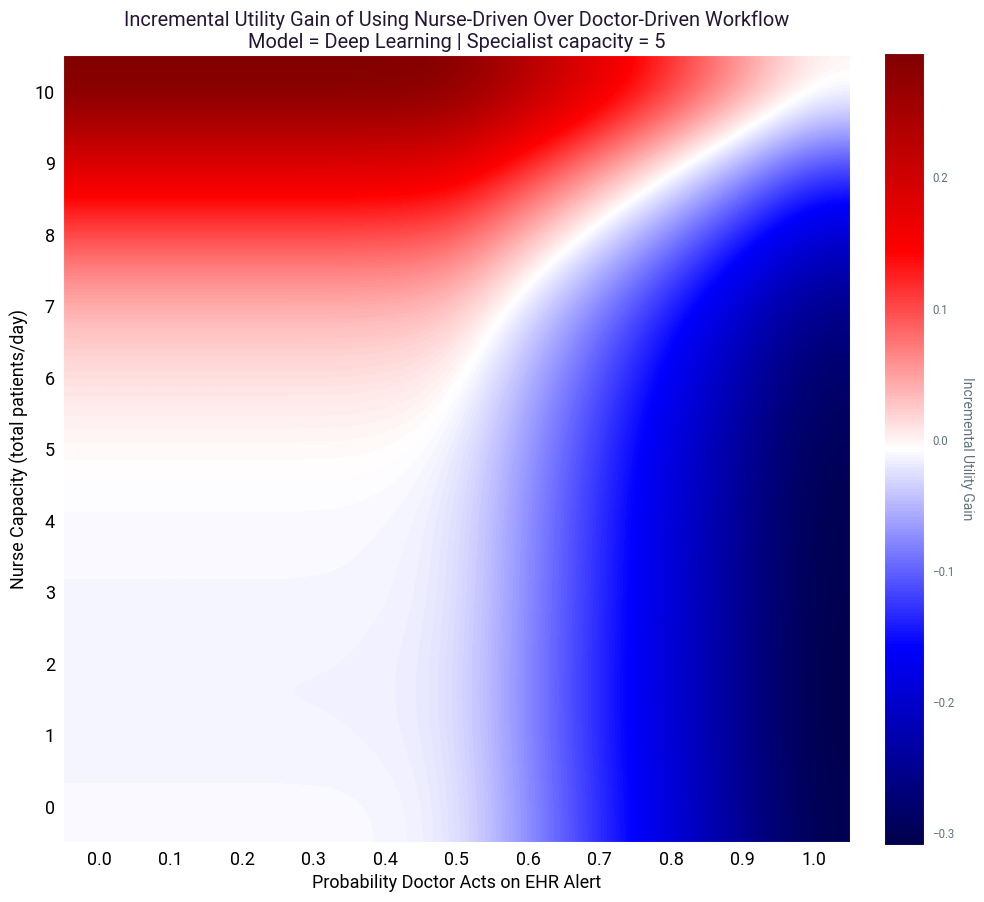

In [48]:
plot_heatmap_doctor_v_nurse(df_nurse_5, df_doctor_5, 'dl', 5, is_discrete_squares=False)

/var/folders/8k/4sr8k5px4pv27s0847cxmvfm0000gp/T/ipykernel_59421/488764404.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/8k/4sr8k5px4pv27s0847cxmvfm0000gp/T/ipykernel_59421/488764404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/8k/4sr8k5px4pv27s0847cxmvfm0000gp/T/ipykernel_59421/488764404.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


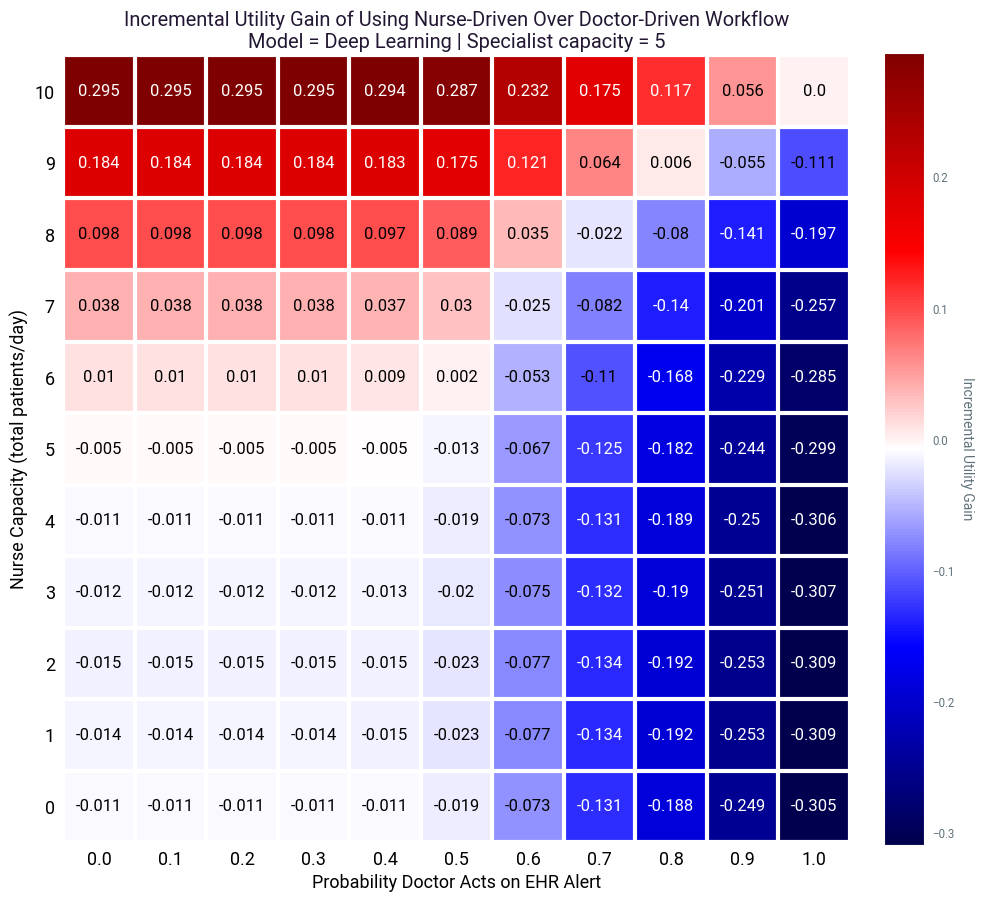

In [49]:
plot_heatmap_doctor_v_nurse(df_nurse_5, df_doctor_5, 'dl', 5, is_discrete_squares=True)

/var/folders/8k/4sr8k5px4pv27s0847cxmvfm0000gp/T/ipykernel_59421/488764404.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/8k/4sr8k5px4pv27s0847cxmvfm0000gp/T/ipykernel_59421/488764404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/8k/4sr8k5px4pv27s0847cxmvfm0000gp/T/ipykernel_59421/488764404.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


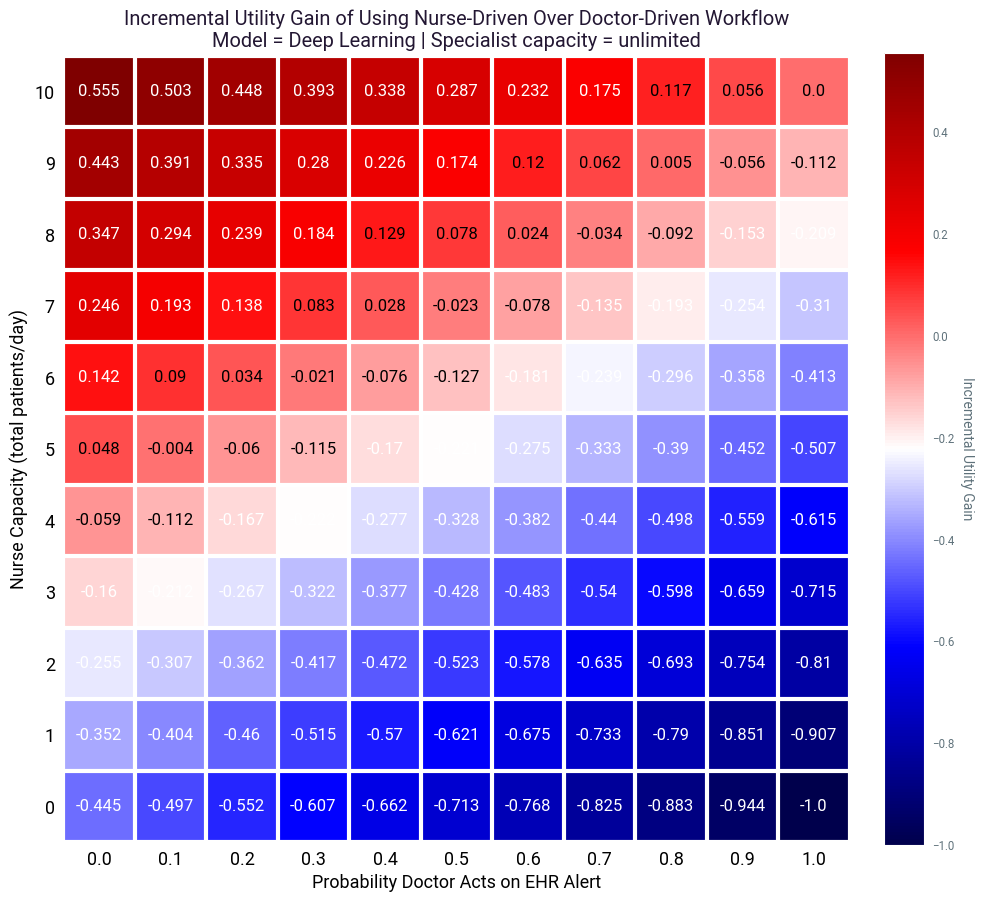

In [50]:
plot_heatmap_doctor_v_nurse(df_nurse_all, df_doctor_all, 'dl', 'unlimited', is_discrete_squares=True)

# Model Performance

In [51]:
# For the purposes of ROC curves, set these baseline utilities
UTILITIES = {
    'tp' : -0.35,
    'fp' : -0.2,
    'tn' : 0,
    'fn' : -1,
}

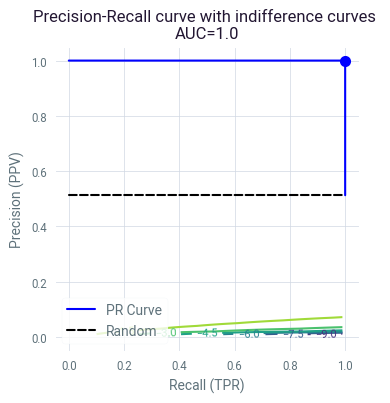

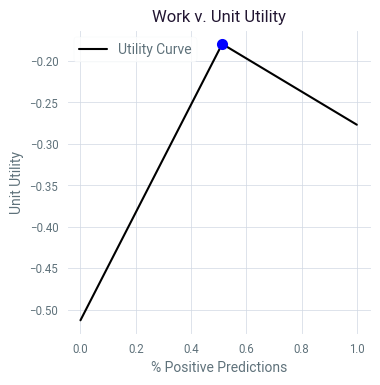

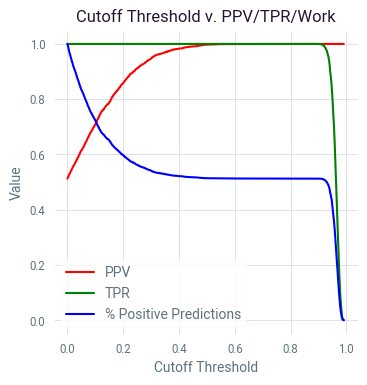

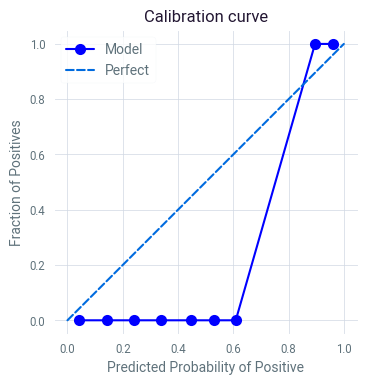

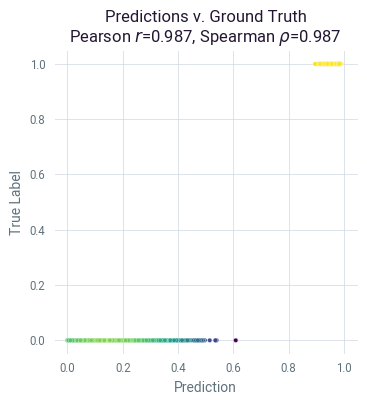

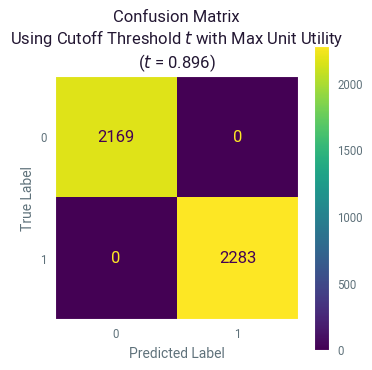

In [52]:
# Deep Learning
aplusml.plot.make_model_utility_plots(df_merged.rename(columns = { 'y_hat_dl' : 'y_hat' }), 
                                        UTILITIES, 
                                        is_show = True)

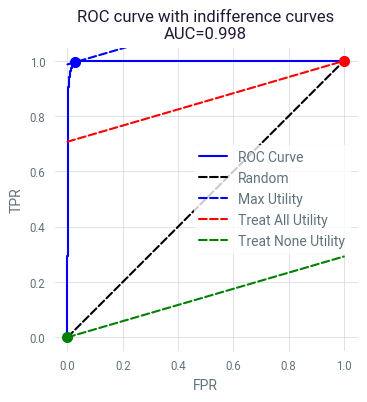

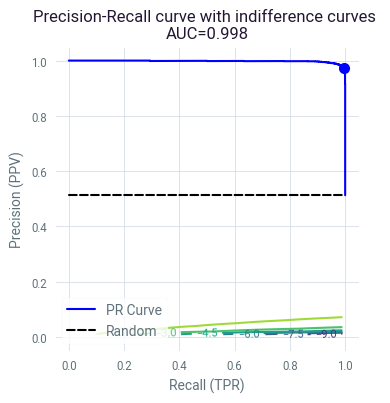

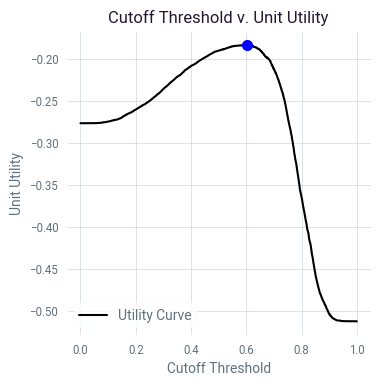

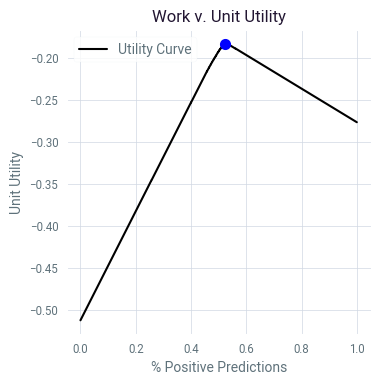

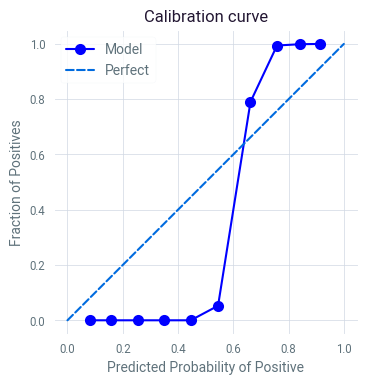

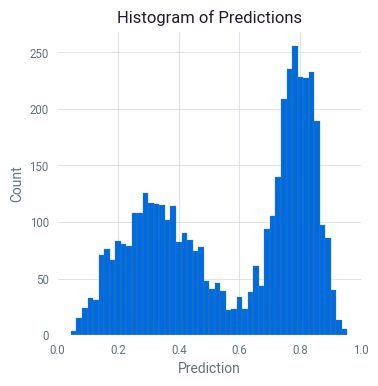

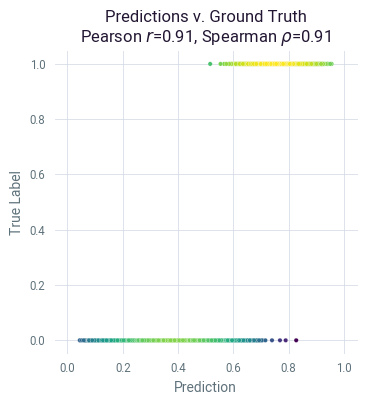

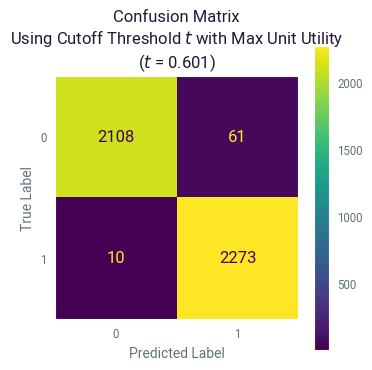

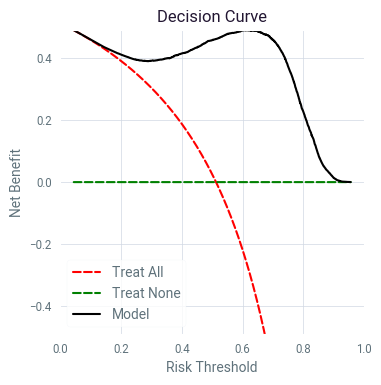

In [53]:
# Random Forest
aplusml.plot.make_model_utility_plots(df_merged.rename(columns = { 'y_hat_rf' : 'y_hat' }), 
                                        UTILITIES, 
                                        is_show = True)

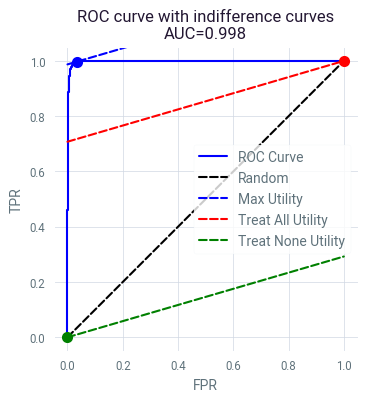

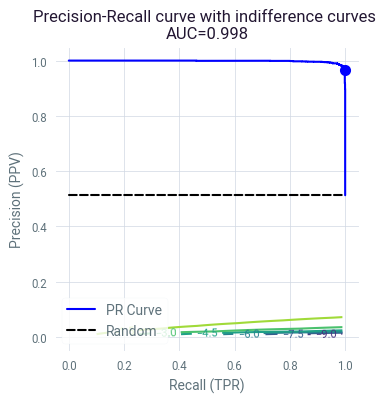

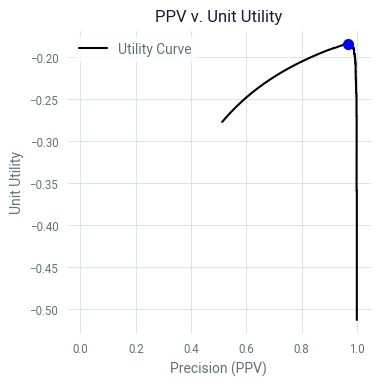

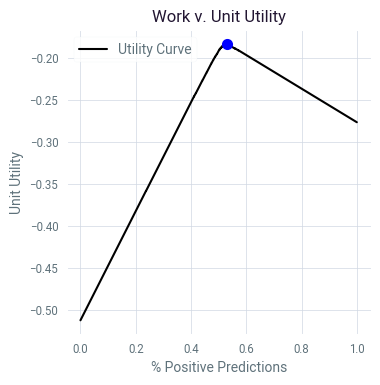

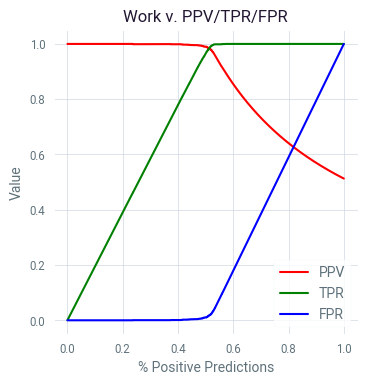

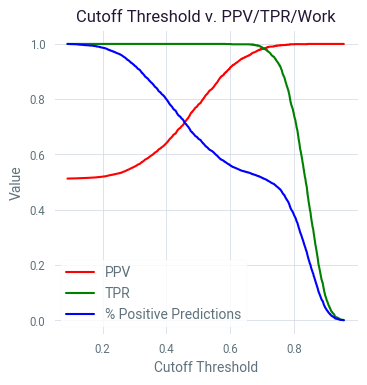

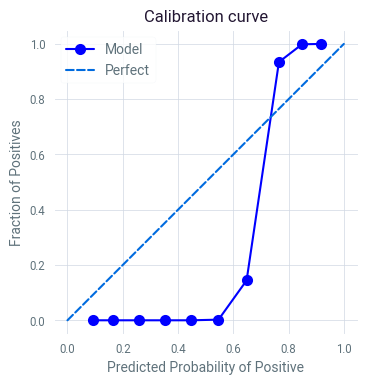

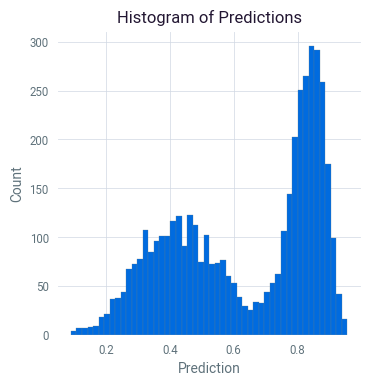

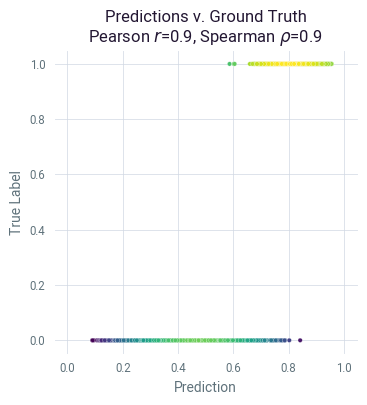

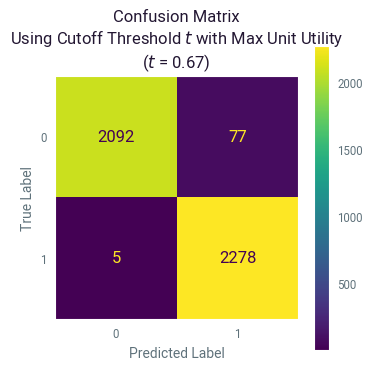

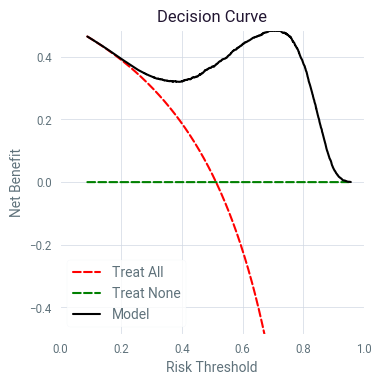

In [54]:
# Logistic Regression
aplusml.plot.make_model_utility_plots(df_merged.rename(columns = { 'y_hat_lr' : 'y_hat' }), 
                                    UTILITIES, 
                                    is_show = True)